# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [ ]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

### 1.2 Collect Images Using OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [7]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [8]:
!labelme

'labelme' 不是內部或外部命令、可執行的程式或批次檔。


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [3]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 2.3 Load Image into TF Data Pipeline

In [6]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data\\images\\*.jpg'

In [ ]:
images.as_numpy_iterator().next()

In [21]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [22]:
images = images.map(load_image)

NameError: name 'images' is not defined

In [15]:
images.as_numpy_iterator().next()

array([[[255, 254, 241],
        [255, 254, 241],
        [255, 254, 241],
        ...,
        [180, 173, 155],
        [180, 173, 154],
        [180, 173, 154]],

       [[255, 254, 241],
        [255, 254, 241],
        [255, 254, 241],
        ...,
        [180, 173, 155],
        [180, 173, 155],
        [180, 173, 154]],

       [[255, 254, 241],
        [255, 254, 241],
        [255, 254, 241],
        ...,
        [180, 173, 155],
        [180, 173, 155],
        [180, 173, 155]],

       ...,

       [[ 55,  40,  43],
        [ 54,  39,  44],
        [ 58,  41,  49],
        ...,
        [169, 157, 119],
        [169, 153, 117],
        [168, 152, 116]],

       [[ 58,  44,  44],
        [ 57,  42,  45],
        [ 59,  42,  50],
        ...,
        [170, 157, 122],
        [170, 154, 120],
        [169, 153, 119]],

       [[ 56,  42,  41],
        [ 56,  42,  42],
        [ 58,  38,  47],
        ...,
        [170, 157, 123],
        [171, 155, 122],
        [170, 154, 121]]

In [16]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

### 2.4 View Raw Images with Matplotlib

In [17]:
image_generator = images.batch(4).as_numpy_iterator()

In [18]:
plot_images = image_generator.next()

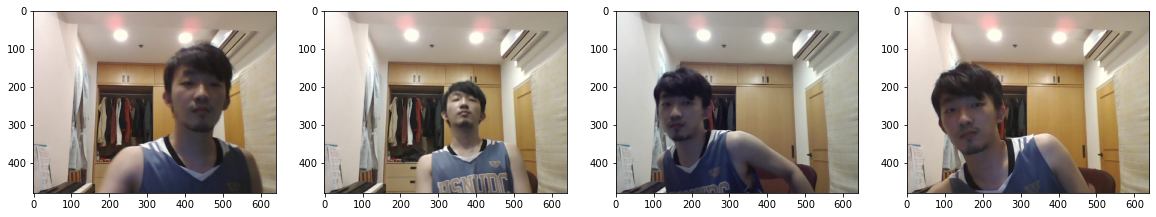

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [26]:
import random

In [30]:
nums = round(90*.7) # 63 to train
image_path = os.path.join('data','images')
train_image_path = os.path.join('data','train','images')
for _ in range(nums-1):
    filename = random.choice(os.listdir(image_path))
    os.replace(os.path.join(image_path,filename),os.path.join(train_image_path,filename))

In [34]:
nums = round(90*.15) # 14 and 13 to test and val
image_path = os.path.join('data','images')
test_image_path = os.path.join('data','test','images')
val_image_path = os.path.join('data','val','images')
for _ in range(nums):
    filename = random.choice(os.listdir(image_path))
    os.replace(os.path.join(image_path,filename),os.path.join(test_image_path,filename))
for _ in range(nums-1):
    filename = random.choice(os.listdir(image_path))
    os.replace(os.path.join(image_path,filename),os.path.join(val_image_path,filename))

### 3.2 Move the Matching Labels

In [35]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [7]:
import albumentations as alb

In [8]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [9]:
img = cv2.imread(os.path.join('data','train', 'images','890d9d1e-d055-11ec-9e15-a0e70bae7c9c.jpg'))

In [10]:
with open(os.path.join('data', 'train', 'labels', '890d9d1e-d055-11ec-9e15-a0e70bae7c9c.json'), 'r') as f:
    label = json.load(f)

In [11]:
label['shapes'][0]['points']

[[261.6666666666667, 90.33333333333333], [552, 479]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [12]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [13]:
coords

[261.6666666666667, 90.33333333333333, 552, 479]

In [14]:
coords = list(np.divide(coords, [640,480,640,480]))

In [15]:
coords

[0.4088541666666667, 0.18819444444444444, 0.8625, 0.9979166666666667]

### 4.4 Apply Augmentations and View Results

In [16]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [17]:
augmented['bboxes'][0][2:]

(0.8955555555555555, 1.0)

In [18]:
augmented['bboxes']

[(0.2503703703703704, 0.13629629629629628, 0.8955555555555555, 1.0)]

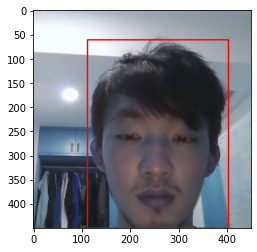

In [19]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [67]:
aug_data = os.path.join('aug_data')
if os.path.isdir(aug_data):
    for folder in ['train','test','val']:
        folder_path = os.path.join(aug_data,folder)
        os.mkdir(folder_path)
        if os.path.isdir(folder_path):
            os.mkdir(os.path.join(folder_path,'labels'))
            os.mkdir(os.path.join(folder_path,'images'))

In [68]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [23]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [24]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [25]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [26]:
train_images.as_numpy_iterator().next()

array([[[0.6189951 , 0.5976103 , 0.65588236],
        [0.62077206, 0.59822303, 0.6462622 ],
        [0.5331495 , 0.5385417 , 0.5983456 ],
        ...,
        [0.41390932, 0.26697305, 0.1872549 ],
        [0.41305146, 0.27518383, 0.19019608],
        [0.4122549 , 0.28382352, 0.18578431]],

       [[0.63039213, 0.6039216 , 0.6573529 ],
        [0.6279412 , 0.597549  , 0.6471814 ],
        [0.6166667 , 0.6122549 , 0.67401963],
        ...,
        [0.40042892, 0.27542892, 0.19307598],
        [0.41862744, 0.28284314, 0.19705883],
        [0.43333334, 0.29644608, 0.20275736]],

       [[0.6377451 , 0.6032475 , 0.65183824],
        [0.6461397 , 0.60790443, 0.6510417 ],
        [0.6259191 , 0.61023283, 0.66813725],
        ...,
        [0.39607844, 0.28627452, 0.2       ],
        [0.42849264, 0.29270834, 0.20692402],
        [0.44313726, 0.3019608 , 0.20784314]],

       ...,

       [[0.71795344, 0.69050246, 0.75324756],
        [0.65857846, 0.6311275 , 0.6938726 ],
        [0.60042894, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [27]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [28]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [29]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [30]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [31]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.4192, 0.    , 1.    , 0.828 ], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [32]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 780, 780)

### 7.2 Create Final Datasets (Images/Labels)

In [33]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [34]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [35]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [36]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.    , 0.246 , 0.5083, 0.8623],
        [0.1615, 0.1852, 0.8013, 1.    ],
        [0.3638, 0.1533, 0.8657, 0.774 ],
        [0.    , 0.1444, 0.3252, 0.801 ],
        [0.4763, 0.506 , 0.86  , 0.903 ],
        [0.    , 0.1888, 0.252 , 0.801 ],
        [0.2925, 0.4275, 0.6113, 0.7812],
        [0.    , 0.2163, 0.0963, 0.797 ]], dtype=float16))

### 7.3 View Images and Annotations

In [37]:
data_samples = train.as_numpy_iterator()

In [38]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


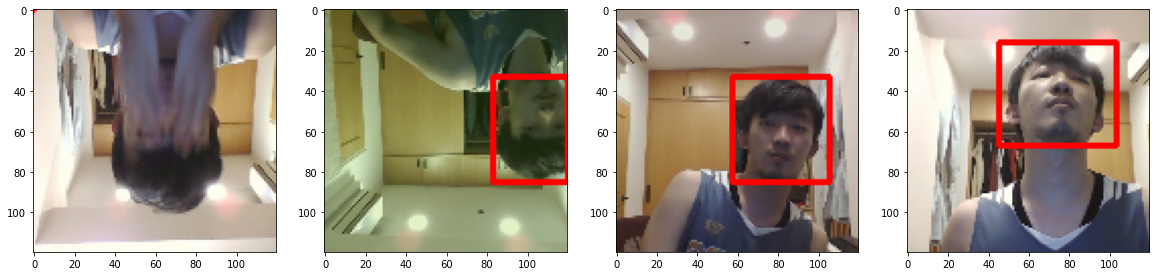

In [39]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [40]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [41]:
vgg = VGG16(include_top=False)

In [42]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [43]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [44]:
facetracker = build_model()

In [45]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, None, None, 5 14714688    input_2[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 512)          0           vgg16[0][0]                      
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 512)          0           vgg16[0][0]                      
______________________________________________________________________________________________

In [46]:
X, y = train.as_numpy_iterator().next()

In [47]:
X.shape

(8, 120, 120, 3)

In [48]:
classes, coords = facetracker.predict(X)

In [51]:
classes, coords

(array([[0.5154678 ],
        [0.41263142],
        [0.38418895],
        [0.44219187],
        [0.35781085],
        [0.39859283],
        [0.49381626],
        [0.40192196]], dtype=float32),
 array([[0.5125876 , 0.27455842, 0.49096152, 0.69519657],
        [0.53652835, 0.32300746, 0.5136938 , 0.58113146],
        [0.5596043 , 0.36551708, 0.5600326 , 0.63296974],
        [0.610764  , 0.27316067, 0.5133306 , 0.6519343 ],
        [0.45558906, 0.2162708 , 0.57253045, 0.6143851 ],
        [0.5714513 , 0.36280385, 0.47093305, 0.5410082 ],
        [0.5713656 , 0.32597163, 0.47721976, 0.6955708 ],
        [0.651066  , 0.355691  , 0.43812218, 0.62042147]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [53]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [54]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [55]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [56]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [57]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.950232>

In [58]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8016701>

In [59]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.950232>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [60]:
class FaceTracker(Model): 
    def __init__(self, facetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [61]:
model = FaceTracker(facetracker)

In [62]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [63]:
logdir='logs'

In [64]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [66]:
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40
473/473 [==============================] - 31s 60ms/step - total_loss: 0.0027 - class_loss: 1.0220e-04 - regress_loss: 0.0026 - val_total_loss: 0.0088 - val_class_loss: 3.7165e-05 - val_regress_loss: 0.0088
Epoch 2/40
473/473 [==============================] - 30s 61ms/step - total_loss: 0.0023 - class_loss: 5.5489e-05 - regress_loss: 0.0023 - val_total_loss: 0.0071 - val_class_loss: 2.3842e-06 - val_regress_loss: 0.0071
Epoch 3/40
473/473 [==============================] - 30s 61ms/step - total_loss: 0.0019 - class_loss: 4.1191e-05 - regress_loss: 0.0019 - val_total_loss: 0.0133 - val_class_loss: 3.3768e-05 - val_regress_loss: 0.0132
Epoch 4/40
473/473 [==============================] - 30s 61ms/step - total_loss: 0.0019 - class_loss: 3.6311e-05 - regress_loss: 0.0019 - val_total_loss: 0.0160 - val_class_loss: 2.3246e-06 - val_regress_loss: 0.0160
Epoch 5/40
473/473 [==============================] - 30s 61ms/step - total_loss: 0.0017 - class_loss: 2.7389e-05 - regress_loss

### 10.3 Plot Performance

In [67]:
hist.history

{'total_loss': [0.002649674890562892,
  0.0008677170262672007,
  0.0010198202216997743,
  0.0023814684245735407,
  0.0011977937538176775,
  0.0004707038460765034,
  0.0005826880224049091,
  0.0005147047340869904,
  0.0005273023853078485,
  0.0005127353360876441,
  0.0006550506222993135,
  0.0007485579699277878,
  0.0004709517234005034,
  0.0014028672594577074,
  0.00027231237618252635,
  0.0003170373965986073,
  0.00035058060893788934,
  0.00023239123402163386,
  0.0003795707016251981,
  0.0004614750505425036,
  0.00014434315380640328,
  0.0005123027367517352,
  0.00018011679640039802,
  0.0002020191604970023,
  0.00024834240321069956,
  0.00018713774625211954,
  0.00018030303181149065,
  0.0001990383752854541,
  0.00019227094890084118,
  0.00020131186465732753,
  0.0003444132744334638,
  8.044825517572463e-05,
  0.00017073181516025215,
  3.7331152270780876e-05,
  0.0001546709827380255,
  0.00018062704475596547,
  0.0001689196506049484,
  0.0003295691276434809,
  8.025272836675867e-05,

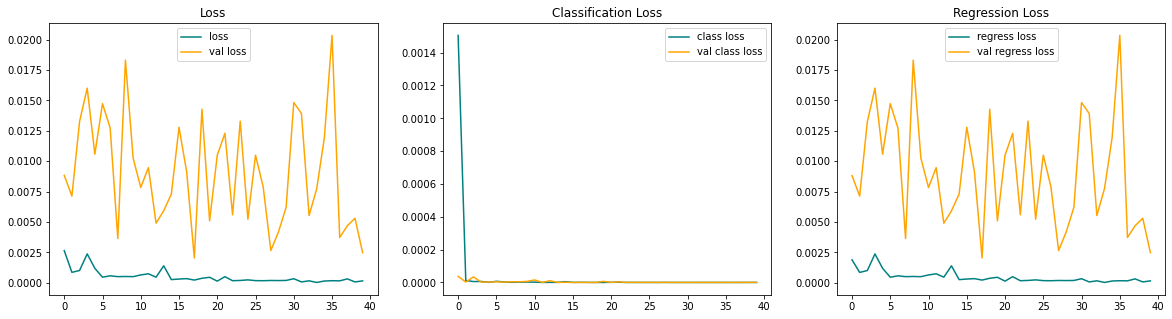

In [68]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [69]:
test_data = test.as_numpy_iterator()

In [85]:
test_sample = test_data.next()

In [86]:
yhat = facetracker.predict(test_sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


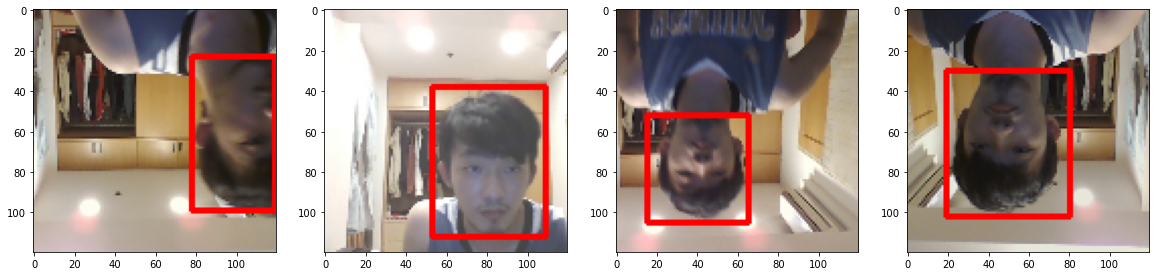

In [87]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [88]:
from tensorflow.keras.models import load_model

In [89]:
facetracker.save('facetracker.h5')

In [90]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [95]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.8: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'Face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()